In [1]:
import numpy as np
import random
import torch

from diffusers import AutoencoderKL, AutoPipelineForText2Image, FlowMatchEulerDiscreteScheduler
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from sd_embed.embedding_funcs import get_weighted_text_embeddings_flux1
from torchao.quantization import quantize_, int8_weight_only
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast

MAX_SEED = np.iinfo(np.int32).max
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16
quantization = int8_weight_only

hg_token = ''
lora_triggers = ''

2024-12-25 18:23:21.140812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 18:23:21.149650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735172601.160779    5590 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735172601.163809    5590 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 18:23:21.175510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def load_flux_pipe(Adult_Content=False, DisneyStyle=False, WaterColor=False):
    global lora_triggers
    # Load the main pipeline without the transformer or text_encoder_2 initially
    pipe = None
    bfl_repo = "black-forest-labs/FLUX.1-dev"
    revision = "refs/pr/3"
    adapter_id = "alimama-creative/FLUX.1-Turbo-Alpha"
    
    scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder="scheduler", revision=revision, token=hg_token)
    #text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    #tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("zer0int/CLIP-GmP-ViT-L-14", torch_dtype=dtype)
    tokenizer = CLIPTokenizer.from_pretrained("zer0int/CLIP-GmP-ViT-L-14", torch_dtype=dtype)
    text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", torch_dtype=dtype, revision=revision, token=hg_token)
    tokenizer_2 = T5TokenizerFast.from_pretrained(bfl_repo, subfolder="tokenizer_2", torch_dtype=dtype, revision=revision, token=hg_token)
    vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder="vae", torch_dtype=dtype, revision=revision, token=hg_token)
    transformer = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder="transformer", torch_dtype=dtype, revision=revision, token=hg_token)
    
    quantize_(transformer, quantization())
    quantize_(text_encoder_2, quantization())
    pipe = FluxPipeline(
        scheduler=scheduler,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        text_encoder_2=text_encoder_2,
        tokenizer_2=tokenizer_2,
        vae=vae,
        transformer=transformer,
    )

    # load loras
    if DisneyStyle:
        # trigger word is egdisney 
        pipe.load_lora_weights('brushpenbob/flux-retro-disney-v2', weight_name='Flux_retro_Disney_v2.safetensors')
        lora_triggers = lora_triggers + 'egdisney, '
    if WaterColor:
        # trigger word is AQUACOLTOK 
        pipe.load_lora_weights('SebastianBodza/Flux_Aquarell_Watercolor_v2', weight_name='lora.safetensors')
        lora_triggers = lora_triggers + 'AQUACOLTOK, '
    if Adult_Content:
        # trigger word is AQUACOLTOK 
        pipe.load_lora_weights('prashanth970/flux-lora-uncensored', weight_name='flux-lora-uncensored.safetensors')
        lora_triggers = lora_triggers + 'porn , nude , sex , boobs, '

    # Move the pipeline to CUDA with bfloat16 precision for performance
    pipe = pipe.to(device, dtype=dtype)
    pipe.load_lora_weights(adapter_id)

    # Enable memory optimizations (attention slicing)
    pipe.enable_attention_slicing()

    return pipe

def gen_flux_image(pipe, prompt, height=1024, width=1024, guidance_scale=3.5, num_inference_steps=8, max_sequence_length=512, seed=-1):
    if seed == -1:
        seed = random.randint(0, MAX_SEED)
        
    prompt_embeds, pooled_prompt_embeds = get_weighted_text_embeddings_flux1(
        pipe        = pipe,
        prompt    = prompt
    )

    with torch.no_grad():
        image = pipe(
            prompt_embeds               = prompt_embeds,
            pooled_prompt_embeds      = pooled_prompt_embeds,
            #prompt=prompt,
            height=height,
            width=width,
            guidance_scale=guidance_scale,
            output_type="pil",
            num_inference_steps=num_inference_steps,
            max_sequence_length=max_sequence_length,
            generator=torch.Generator("cpu").manual_seed(seed)
        ).images[0]
    return image

In [3]:
pipe = load_flux_pipe()

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

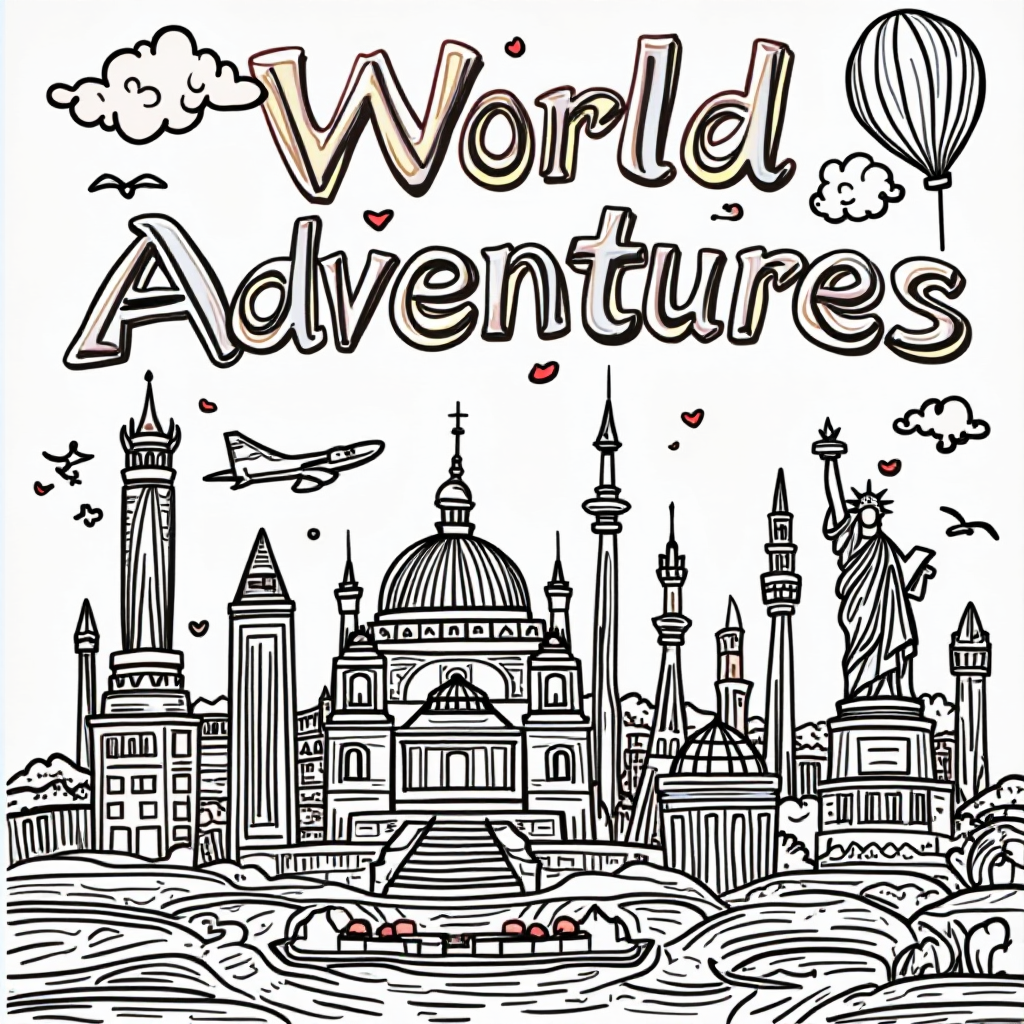

In [4]:
prompt = '''A colored in cover page titled "World Adventures" for a coloring book.  The cover page has famous world land marks that are colored in with crayon, with a diagonal black and white strip that is not colored in.  There is a colored in balloon in the corner.'''

In [ ]:
image = gen_flux_image(pipe, prompt)
image